## Task 10: Plotting Bias-Variance Tradeoff and Correlation

In [1]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt
import glob


from algorithms import BMP
from data_generation import GaussianDataGenerator

In [2]:
pkl_files = glob.glob(os.path.join(os.getcwd(), "*.pkl"))
temp_pkl_file_name = pkl_files[0]
with open(temp_pkl_file_name, 'rb') as f:
    temp_data = pkl.load(f)[0]

In [3]:

temp_data_parameters = temp_data['parameters']
temp_data_log = temp_data['log'][0]


single_log_from_temp_data = temp_data_log[0]
single_trial_id = single_log_from_temp_data['trial']

train_X, test_X, train_y, test_y = single_log_from_temp_data['dataset']
K_coef_lst_mat = single_log_from_temp_data['K_coef_lst_mat']
K_final_coef_mat =  single_log_from_temp_data['K_final_coef_mat']

n = temp_data_parameters['n']
p = temp_data_parameters['p']
m = temp_data_parameters['m']
noise_level = single_log_from_temp_data['noise_level']

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, single_trial_id)
true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
real_coefficients = np.zeros(p)
real_coefficients[true_indices] = true_coefficients.flatten()

In [4]:
def return_cov_and_cor_for_single_k(coef_mat):
    cov_list = []
    cor_list = []
    for i in range(coef_mat.shape[0]):
        single_K_in_single_trial = coef_mat[i,:,:]
        single_estimation_cov_matrix = np.cov(single_K_in_single_trial)
        single_estimation_corr_matrix = np.corrcoef(single_K_in_single_trial)
        tril_idx = np.tril_indices(single_estimation_cov_matrix.shape[0], -1)
        cov_list.append(single_estimation_cov_matrix[tril_idx].mean())
        cor_list.append(single_estimation_corr_matrix[tril_idx].mean())
    return np.array(cov_list), np.array(cor_list)


def calculate_statistics_given_coefficients(
    K_final_coef_mat,
    K_coef_lst_mat,
    train_X,
    train_y,
    test_X,
    test_y,
    real_coefficients,
):
    single_estimation_variance = K_coef_lst_mat.var(axis=1).mean(axis=1)
    single_training_error = (((train_X @ K_final_coef_mat.T) - train_y)**2).mean(axis=0)
    single_testing_error = (((test_X @ K_final_coef_mat.T) - test_y)**2).mean(axis=0)
    single_estimation_bias = ((K_final_coef_mat - real_coefficients)**2).mean(axis=1)
    single_estimation_cov, single_estimation_corr = return_cov_and_cor_for_single_k(K_coef_lst_mat)
    return (
        single_estimation_variance,
        single_estimation_bias,
        single_estimation_cov,
        single_estimation_corr,
        single_training_error,
        single_testing_error,
    )
def summarize_one_log(temp_data_parameters,single_log_from_temp_data):
    single_trial_id = single_log_from_temp_data['trial']

    train_X, test_X, train_y, test_y = single_log_from_temp_data['dataset']
    K_coef_lst_mat = single_log_from_temp_data['K_coef_lst_mat']
    K_final_coef_mat =  single_log_from_temp_data['K_final_coef_mat']

    n = temp_data_parameters['n']
    p = temp_data_parameters['p']
    m = temp_data_parameters['m']
    noise_level = single_log_from_temp_data['noise_level']

    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, single_trial_id)
    true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
    real_coefficients = np.zeros(p)
    real_coefficients[true_indices] = true_coefficients.flatten()


    single_estimation_variance, single_estimation_bias, single_estimation_cov, single_estimation_corr, single_training_error, single_testing_error = calculate_statistics_given_coefficients(
        K_final_coef_mat,
        K_coef_lst_mat,
        train_X,
        train_y,
        test_X,
        test_y,
        real_coefficients,
    )

    indexed_K_final_coef_mat = K_final_coef_mat[:, true_indices]
    indexed_K_coef_lst_mat = K_coef_lst_mat[:, :, true_indices]
    indexed_train_X = train_X[:, true_indices]
    indexed_test_X = test_X[:, true_indices]
    indexed_train_y = train_y.copy()
    indexed_test_y = test_y.copy()
    indexed_real_coefficients = real_coefficients[true_indices]

    indexed_single_estimation_variance, indexed_single_estimation_bias, indexed_single_estimation_cov, indexed_single_estimation_corr, indexed_single_training_error, indexed_single_testing_error = calculate_statistics_given_coefficients(
        indexed_K_final_coef_mat,
        indexed_K_coef_lst_mat,
        indexed_train_X,
        indexed_train_y,
        indexed_test_X,
        indexed_test_y,
        indexed_real_coefficients,
    )

    return {
        'single_estimation_variance': single_estimation_variance,
        'single_estimation_bias': single_estimation_bias,
        'single_estimation_cov': single_estimation_cov,
        'single_estimation_corr': single_estimation_corr,
        'single_training_error': single_training_error,
        'single_testing_error': single_testing_error,
        'indexed_single_estimation_variance': indexed_single_estimation_variance,
        'indexed_single_estimation_bias': indexed_single_estimation_bias,
        'indexed_single_estimation_cov': indexed_single_estimation_cov,
        'indexed_single_estimation_corr': indexed_single_estimation_corr,
        'indexed_single_training_error': indexed_single_training_error,
        'indexed_single_testing_error': indexed_single_testing_error,
    }


In [5]:
temp_data_parameters = temp_data['parameters']
temp_data_log = temp_data['log'][0]


K_list = temp_data['parameters']['param_grid']['K']
trial_num = temp_data_parameters['trial_num']
estimation_variance = np.zeros((trial_num, len(K_list)))
estimation_bias = np.zeros((trial_num, len(K_list)))
estimation_cov = np.zeros((trial_num, len(K_list)))
estimation_corr = np.zeros((trial_num, len(K_list)))
training_error = np.zeros((trial_num, len(K_list)))
testing_error = np.zeros((trial_num, len(K_list)))
indexed_estimation_variance = np.zeros((trial_num, len(K_list)))
indexed_estimation_bias = np.zeros((trial_num, len(K_list)))
indexed_estimation_cov = np.zeros((trial_num, len(K_list)))
indexed_estimation_corr = np.zeros((trial_num, len(K_list)))
indexed_training_error = np.zeros((trial_num, len(K_list)))
indexed_testing_error = np.zeros((trial_num, len(K_list)))


for log_index in range(len(temp_data_log)):
    calculation_results = summarize_one_log(temp_data_parameters, temp_data_log[log_index])
    estimation_variance[log_index, :] = calculation_results['single_estimation_variance']
    estimation_bias[log_index, :] = calculation_results['single_estimation_bias']
    estimation_cov[log_index, :] = calculation_results['single_estimation_cov']
    estimation_corr[log_index, :] = calculation_results['single_estimation_corr']
    training_error[log_index, :] = calculation_results['single_training_error']
    testing_error[log_index, :] = calculation_results['single_testing_error']
    indexed_estimation_variance[log_index, :] = calculation_results['indexed_single_estimation_variance']
    indexed_estimation_bias[log_index, :] = calculation_results['indexed_single_estimation_bias']
    indexed_estimation_cov[log_index, :] = calculation_results['indexed_single_estimation_cov']
    indexed_estimation_corr[log_index, :] = calculation_results['indexed_single_estimation_corr']
    indexed_training_error[log_index, :] = calculation_results['indexed_single_training_error']
    indexed_testing_error[log_index, :] = calculation_results['indexed_single_testing_error']


/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:
pkl_files = glob.glob(os.path.join(os.getcwd(), "*.pkl"))
pkl_files

['/Users/zsr/PersonalCoding/Local Projection Pursuit/Result Analysis/August 1/bmp_agg_300_600_20_0908_N0220230729-192212-002.pkl',
 '/Users/zsr/PersonalCoding/Local Projection Pursuit/Result Analysis/August 1/bomp_agg_300_600_20_0908_N0220230729-192212-001.pkl',
 '/Users/zsr/PersonalCoding/Local Projection Pursuit/Result Analysis/August 1/bmp_agg_300_600_20_0806_N0220230729-192216-003.pkl']

In [47]:
def data_loader(pkl_file_path):
    temp_data = None
    with open(pkl_file_path, 'rb') as f:
        temp_data = pkl.load(f)[0]
    temp_data_parameters = temp_data['parameters']

    return temp_data, temp_data_parameters
    
def parameter_loader(temp_data_parameters):
    n = temp_data_parameters['n']
    p = temp_data_parameters['p']
    m = temp_data_parameters['m']
    noise_level = temp_data_parameters['noise_level_lst'][0]
    model_name = temp_data_parameters['model_name']
    signal_bag_percent = temp_data_parameters['fixed_params']['signal_bag_percent']
    atom_bag_percent = temp_data_parameters['fixed_params']['atom_bag_percent']
    trial_num = temp_data_parameters['trial_num']

    return n, p, m, noise_level, model_name, signal_bag_percent, atom_bag_percent, trial_num

def calculate_single_pkl_statistics(temp_data_log,temp_data_parameters, trial_num, K_list):
    estimation_variance = np.zeros((trial_num, len(K_list)))
    estimation_bias = np.zeros((trial_num, len(K_list)))
    estimation_cov = np.zeros((trial_num, len(K_list)))
    estimation_corr = np.zeros((trial_num, len(K_list)))
    training_error = np.zeros((trial_num, len(K_list)))
    testing_error = np.zeros((trial_num, len(K_list)))
    indexed_estimation_variance = np.zeros((trial_num, len(K_list)))
    indexed_estimation_bias = np.zeros((trial_num, len(K_list)))
    indexed_estimation_cov = np.zeros((trial_num, len(K_list)))
    indexed_estimation_corr = np.zeros((trial_num, len(K_list)))
    indexed_training_error = np.zeros((trial_num, len(K_list)))
    indexed_testing_error = np.zeros((trial_num, len(K_list)))


    for log_index in range(len(temp_data_log)):
        calculation_results = summarize_one_log(temp_data_parameters, temp_data_log[log_index])
        estimation_variance[log_index, :] = calculation_results['single_estimation_variance']
        estimation_bias[log_index, :] = calculation_results['single_estimation_bias']
        estimation_cov[log_index, :] = calculation_results['single_estimation_cov']
        estimation_corr[log_index, :] = calculation_results['single_estimation_corr']
        training_error[log_index, :] = calculation_results['single_training_error']
        testing_error[log_index, :] = calculation_results['single_testing_error']
        indexed_estimation_variance[log_index, :] = calculation_results['indexed_single_estimation_variance']
        indexed_estimation_bias[log_index, :] = calculation_results['indexed_single_estimation_bias']
        indexed_estimation_cov[log_index, :] = calculation_results['indexed_single_estimation_cov']
        indexed_estimation_corr[log_index, :] = calculation_results['indexed_single_estimation_corr']
        indexed_training_error[log_index, :] = calculation_results['indexed_single_training_error']
        indexed_testing_error[log_index, :] = calculation_results['indexed_single_testing_error']

    return estimation_variance.mean(axis=0), estimation_bias.mean(axis=0), estimation_cov.mean(axis=0), estimation_corr.mean(axis=0), training_error.mean(axis=0), testing_error.mean(axis=0), indexed_estimation_variance.mean(axis=0), indexed_estimation_bias.mean(axis=0), indexed_estimation_cov.mean(axis=0), indexed_estimation_corr.mean(axis=0), indexed_training_error.mean(axis=0), indexed_testing_error.mean(axis=0)



fig_sav_path = 'result_analysis_figures/'
if not os.path.exists(fig_sav_path):
    os.makedirs(fig_sav_path)


def viz_for_single_pkl_file(pkl_file_path):
    temp_data, temp_data_parameters = data_loader(pkl_file_path)
    n, p, m, noise_level, model_name, signal_bag_percent, atom_bag_percent, trial_num = parameter_loader(temp_data_parameters)
    print("Current Parameters Setting is:"+str(temp_data_parameters))

    temp_data_log = temp_data['log'][0]
    K_list = temp_data['parameters']['param_grid']['K']
    estimation_variance_mean, estimation_bias_mean, estimation_cov_mean, estimation_corr_mean, training_error_mean, testing_error_mean, indexed_estimation_variance_mean, indexed_estimation_bias_mean, indexed_estimation_cov_mean, indexed_estimation_corr_mean, indexed_training_error_mean, indexed_testing_error_mean = calculate_single_pkl_statistics(temp_data_log,temp_data_parameters, trial_num, K_list)


    # assuming *_mean variables are defined
    variable_names = ['estimation_variance', 'estimation_bias', 'estimation_cov', 'estimation_corr', 
                    'training_error', 'testing_error', 'indexed_estimation_variance', 'indexed_estimation_bias',
                    'indexed_estimation_cov', 'indexed_estimation_corr', 'indexed_training_error', 'indexed_testing_error']


    fig, axes = plt.subplots(3, 2, figsize=(16, 24))  # 2 rows, 3 columns
    axes = axes.ravel()  # flatten axes

    # Create a new figure for each pair of variables
    for i, var_name in enumerate(['estimation_variance', 'estimation_bias', 'estimation_cov', 'estimation_corr', 
                                'training_error', 'testing_error']):
            
        indexed_var_name = 'indexed_' + var_name
        # Add lines
        axes[i].plot(K_list, eval(var_name + "_mean"), color='blue', label="Original")
        axes[i].plot(K_list, eval(indexed_var_name + "_mean"), color='red', label="Indexed")
        axes[i].set_title(var_name + f' vs. K at ' + ', noise_level = ' + str(noise_level) + '\n, ' + 'atom_bag_percent = ' + str(atom_bag_percent) + ', ' + 'signal_bag_percent = ' + str(signal_bag_percent) + ', '+ model_name)
        # Add legend
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    # Adjust the layout
    plt.tight_layout()

    # Save the figure before showing it
    plt.savefig(os.path.join(fig_sav_path, model_name + '_noise_level_' + str(noise_level) + '_atom_bag_percent_' + str(atom_bag_percent) + '_signal_bag_percent_' + str(signal_bag_percent) + '.png'),dpi=300)

    # Show the plot
    plt.show()


Current Parameters Setting is:{'n': 300, 'p': 600, 'm': 20, 'noise_level_lst': [0.2], 'model_name': 'BMP', 'cv_num': 5, 'trial_num': 25, 'param_grid': {'K': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}, 'fixed_params': {'N_bag': 500, 'signal_bag_percent': 0.9, 'atom_bag_percent': 0.8, 'select_atom_percent': 0, 'replace_flag': False, 'agg_func': 'weight', 'ignore_warning': True, 'random_seed': None}}


/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


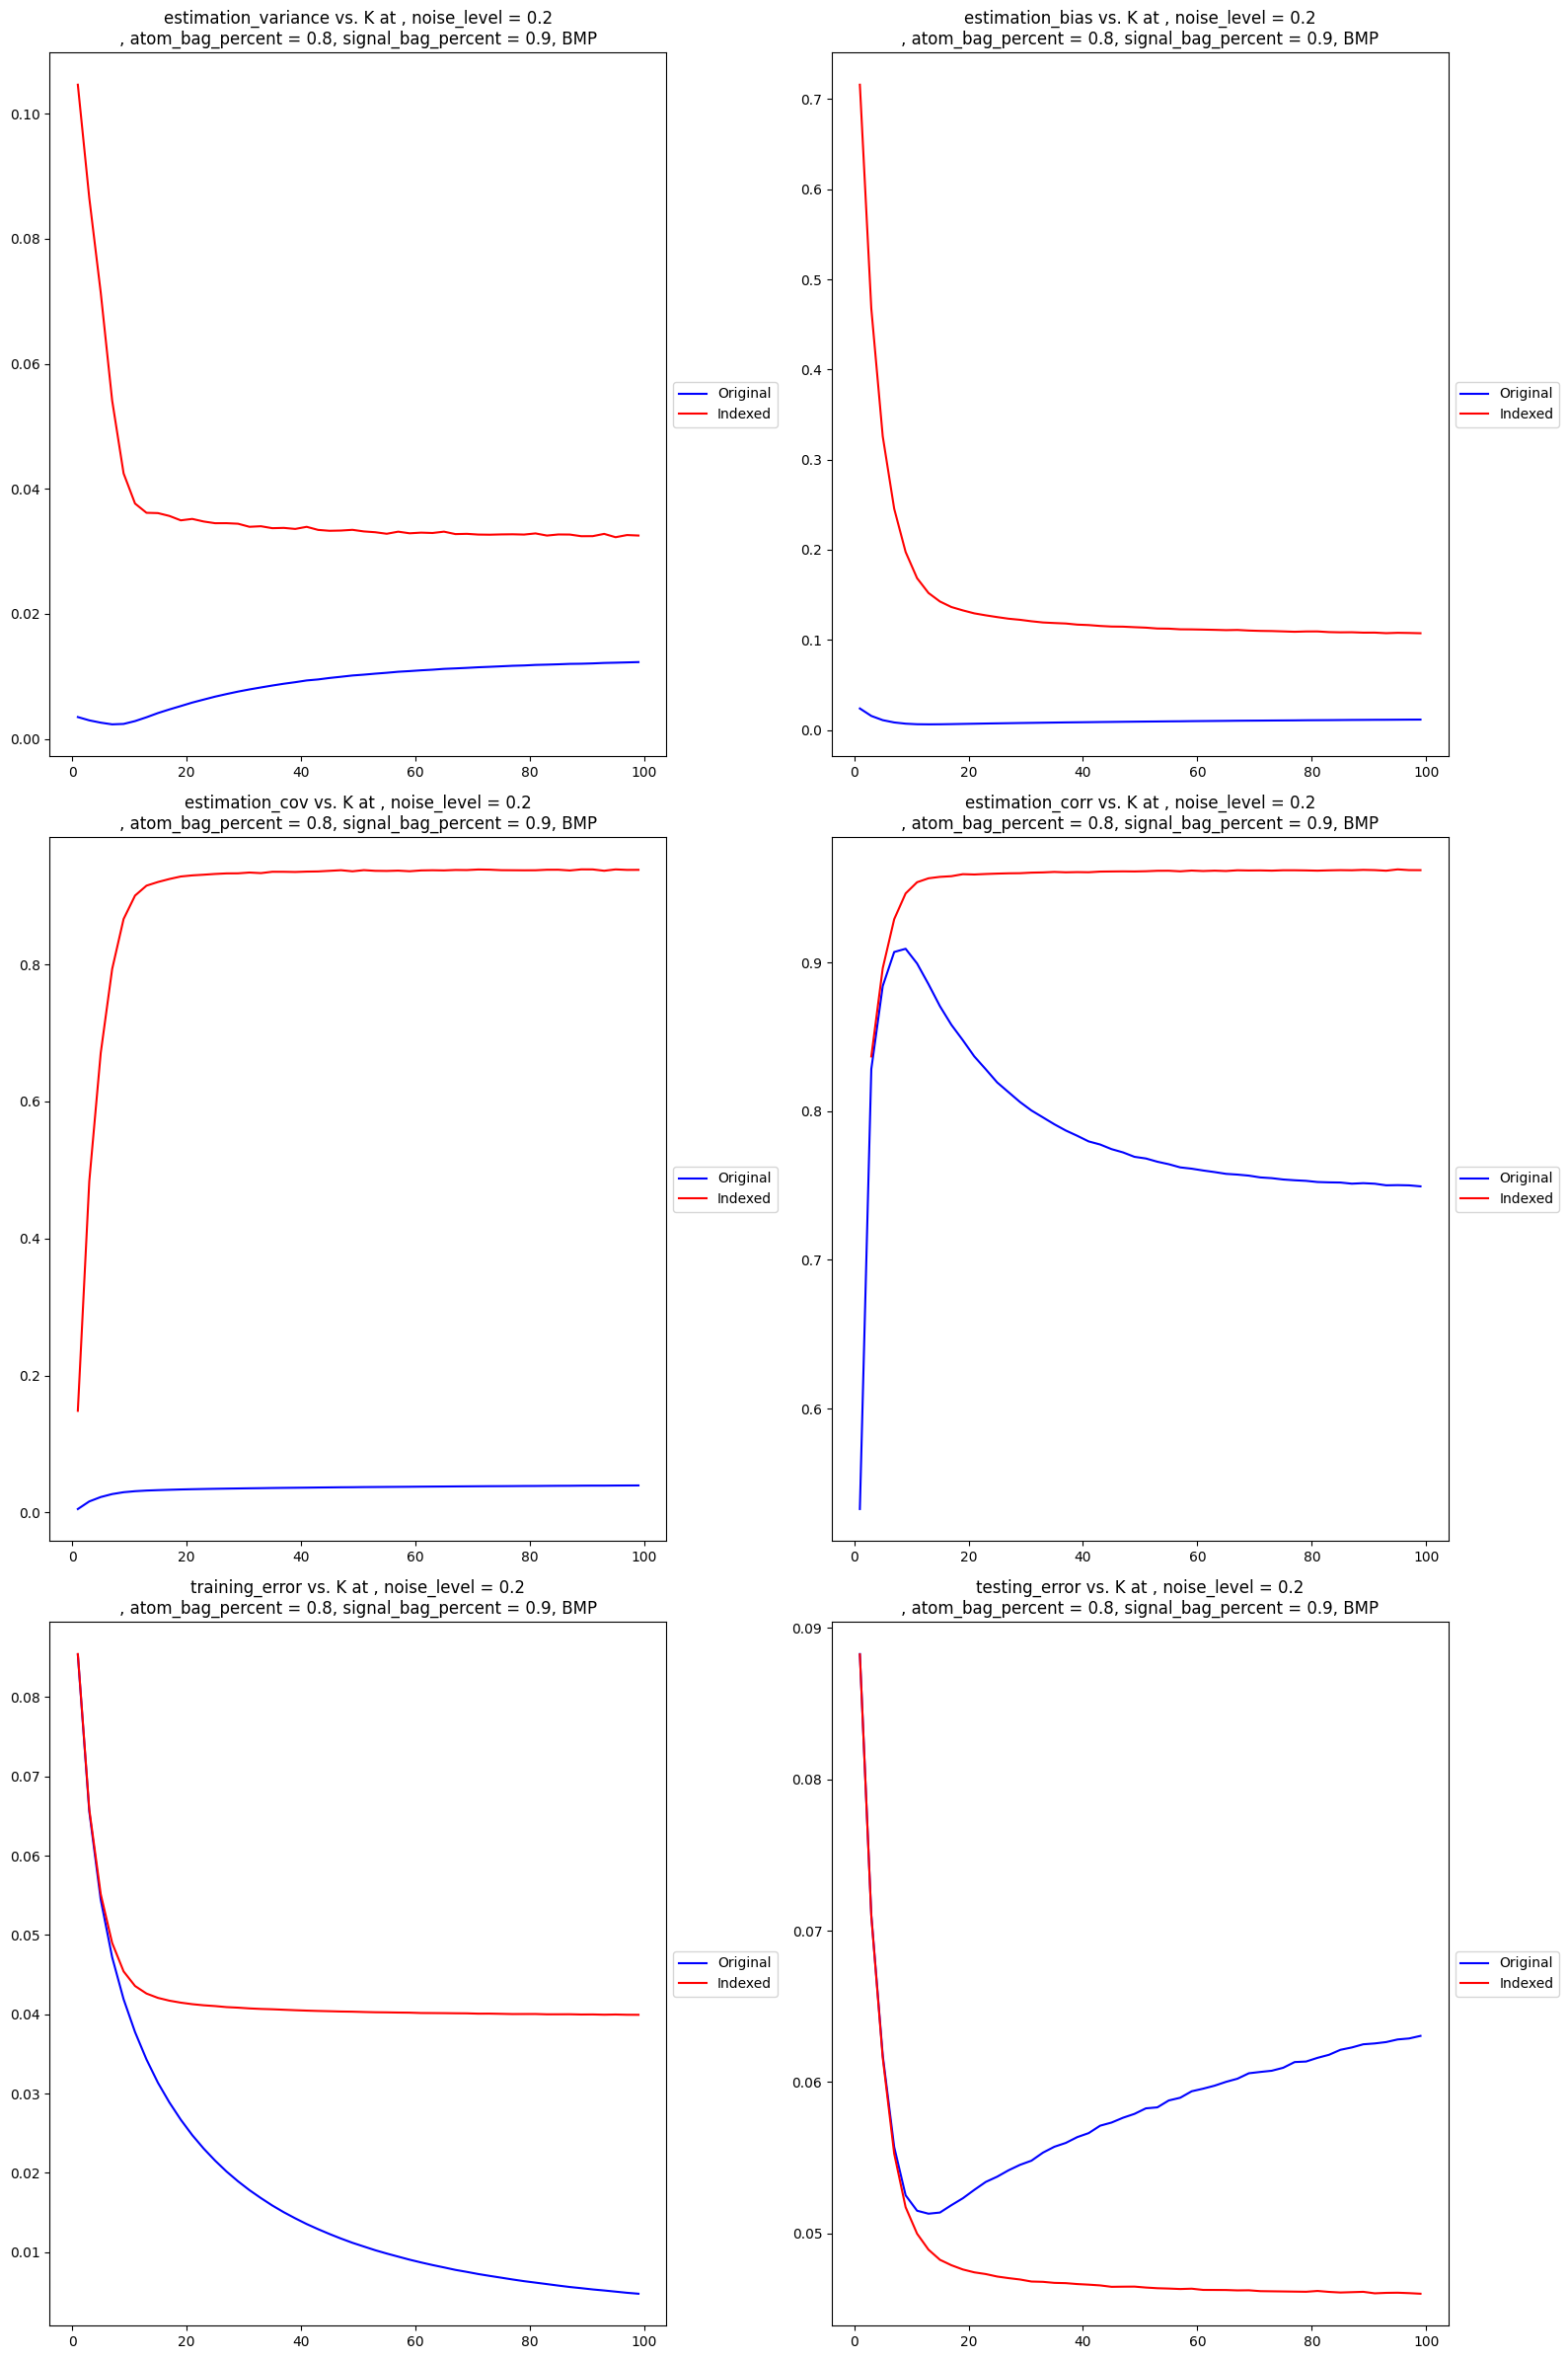

In [48]:
viz_for_single_pkl_file(pkl_files[0])

Current Parameters Setting is:{'n': 300, 'p': 600, 'm': 20, 'noise_level_lst': [0.2], 'model_name': 'BOMP', 'cv_num': 5, 'trial_num': 25, 'param_grid': {'K': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}, 'fixed_params': {'N_bag': 500, 'signal_bag_percent': 0.9, 'atom_bag_percent': 0.8, 'select_atom_percent': 0, 'replace_flag': False, 'agg_func': 'weight', 'ignore_warning': True, 'random_seed': None}}


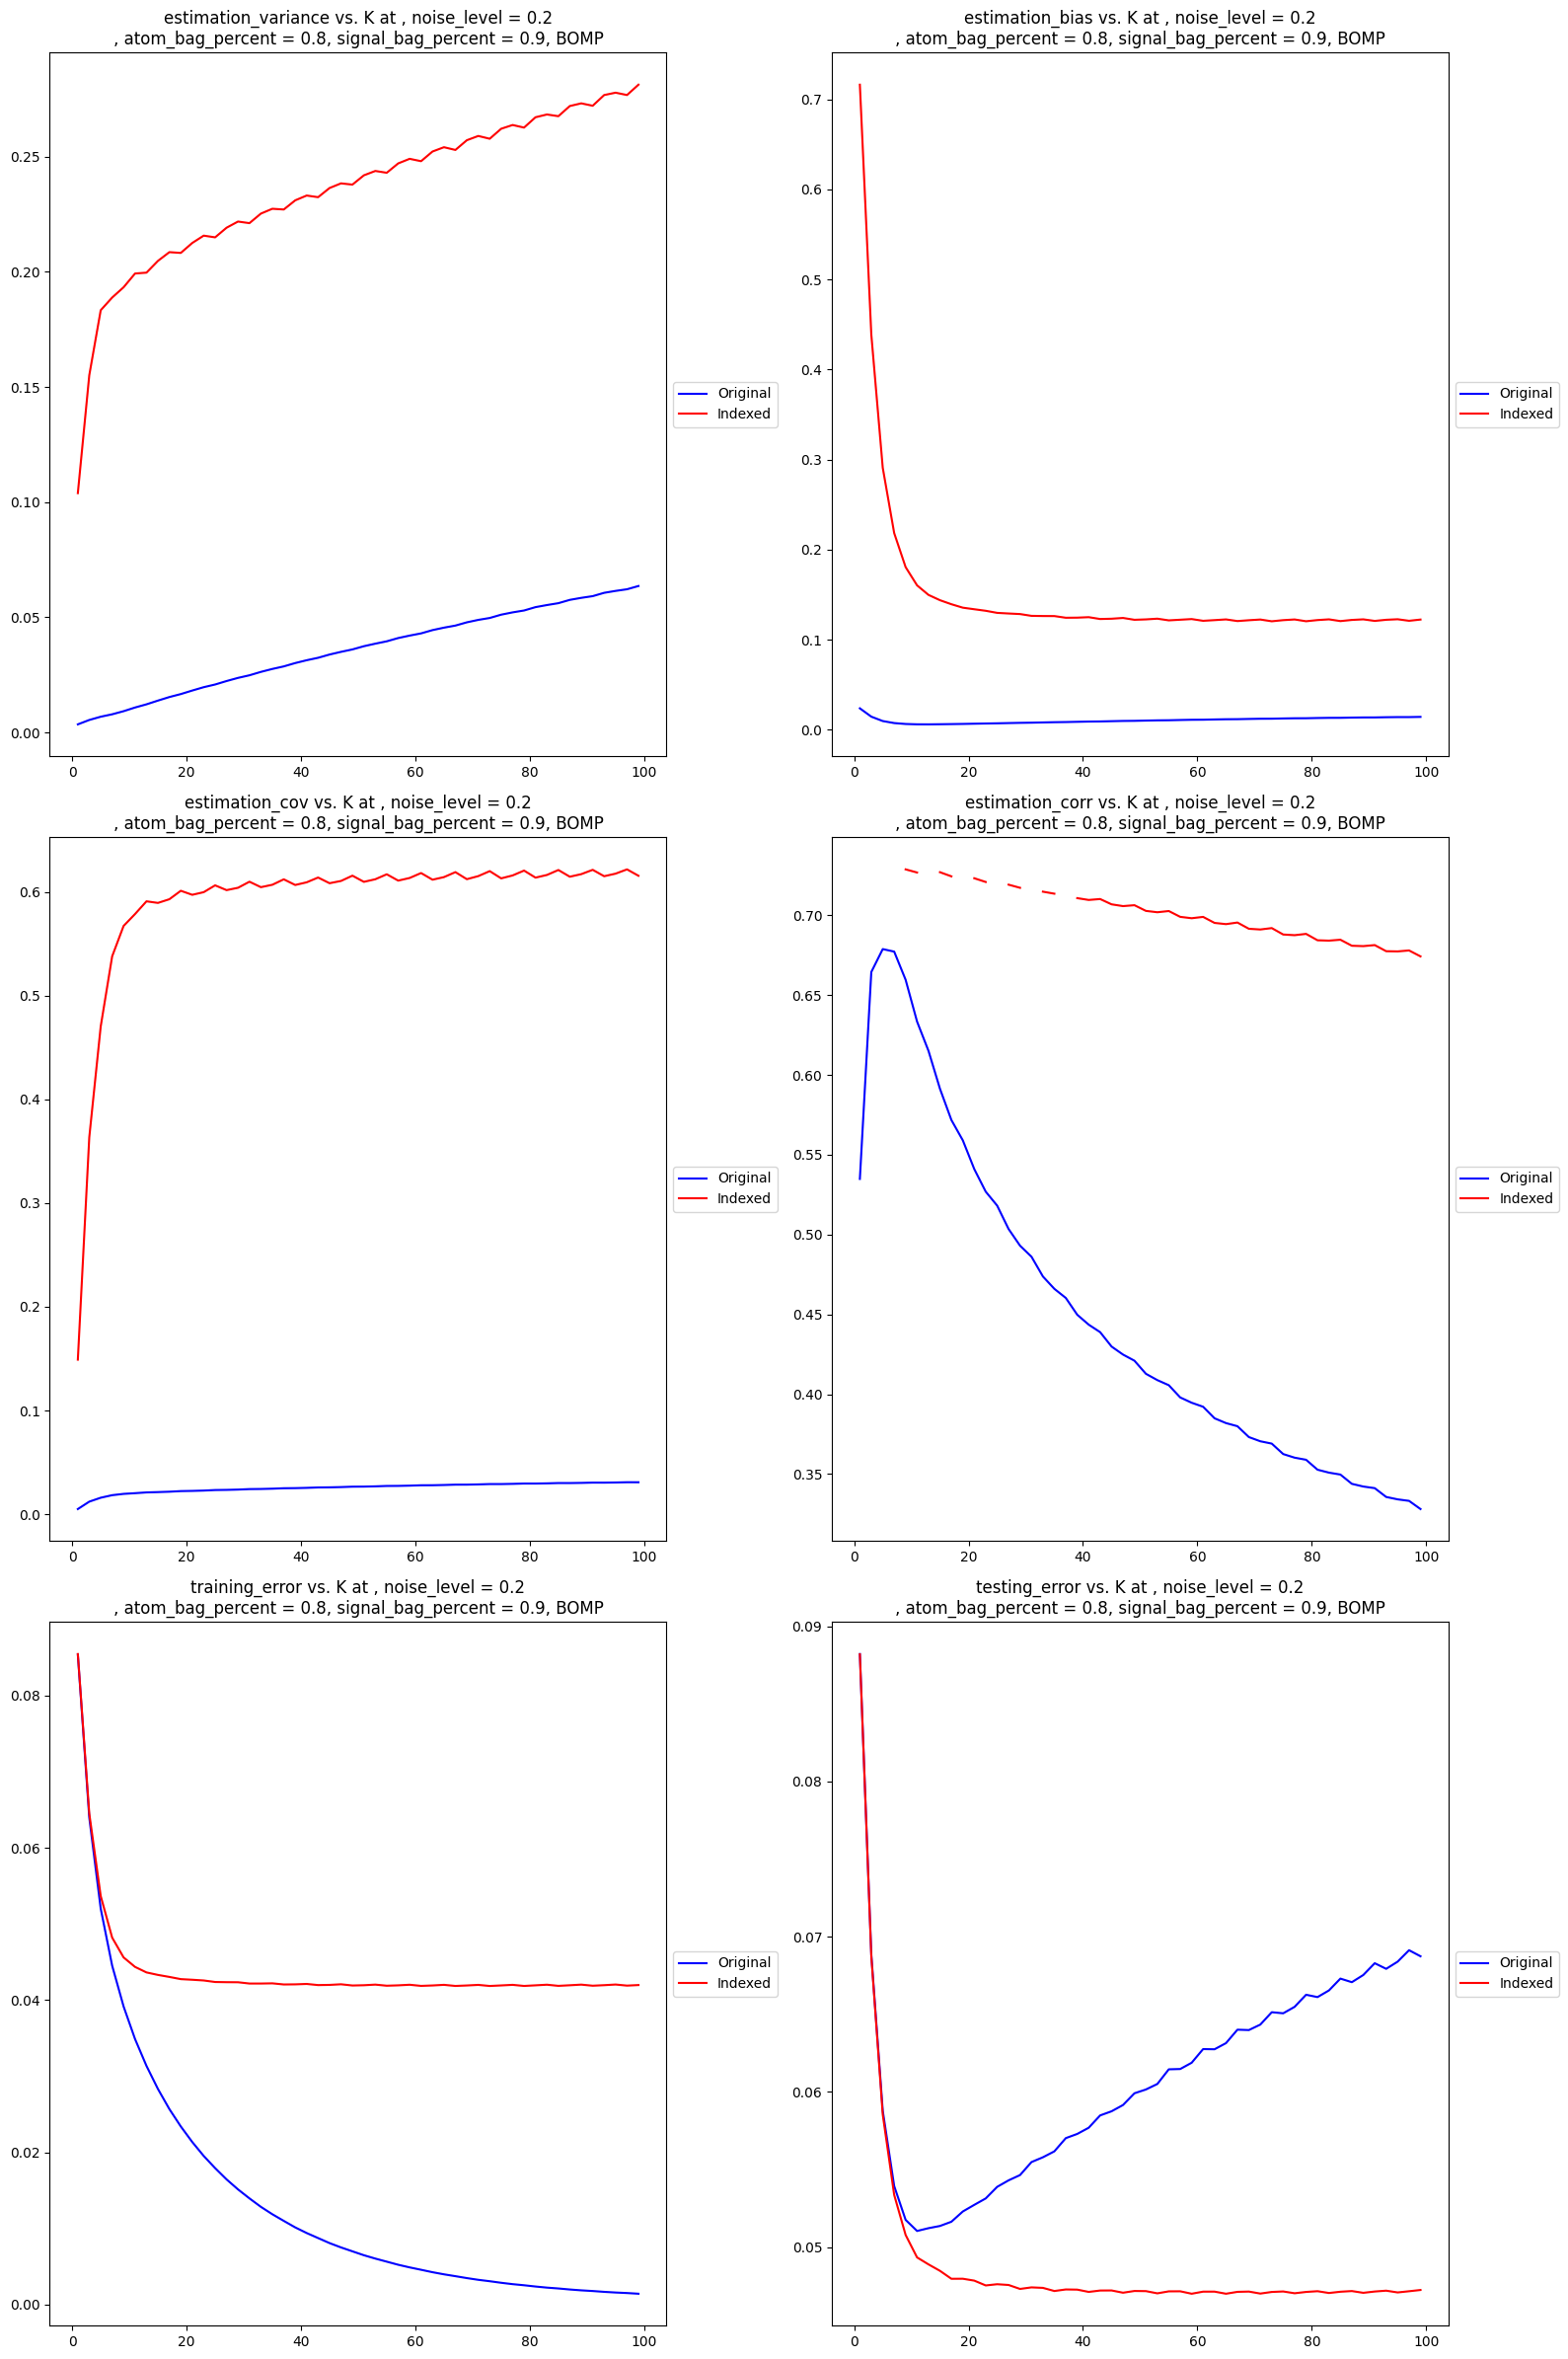

In [49]:
viz_for_single_pkl_file(pkl_files[1])

Current Parameters Setting is:{'n': 300, 'p': 600, 'm': 20, 'noise_level_lst': [0.2], 'model_name': 'BMP', 'cv_num': 5, 'trial_num': 25, 'param_grid': {'K': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}, 'fixed_params': {'N_bag': 500, 'signal_bag_percent': 0.8, 'atom_bag_percent': 0.6, 'select_atom_percent': 0, 'replace_flag': False, 'agg_func': 'weight', 'ignore_warning': True, 'random_seed': None}}


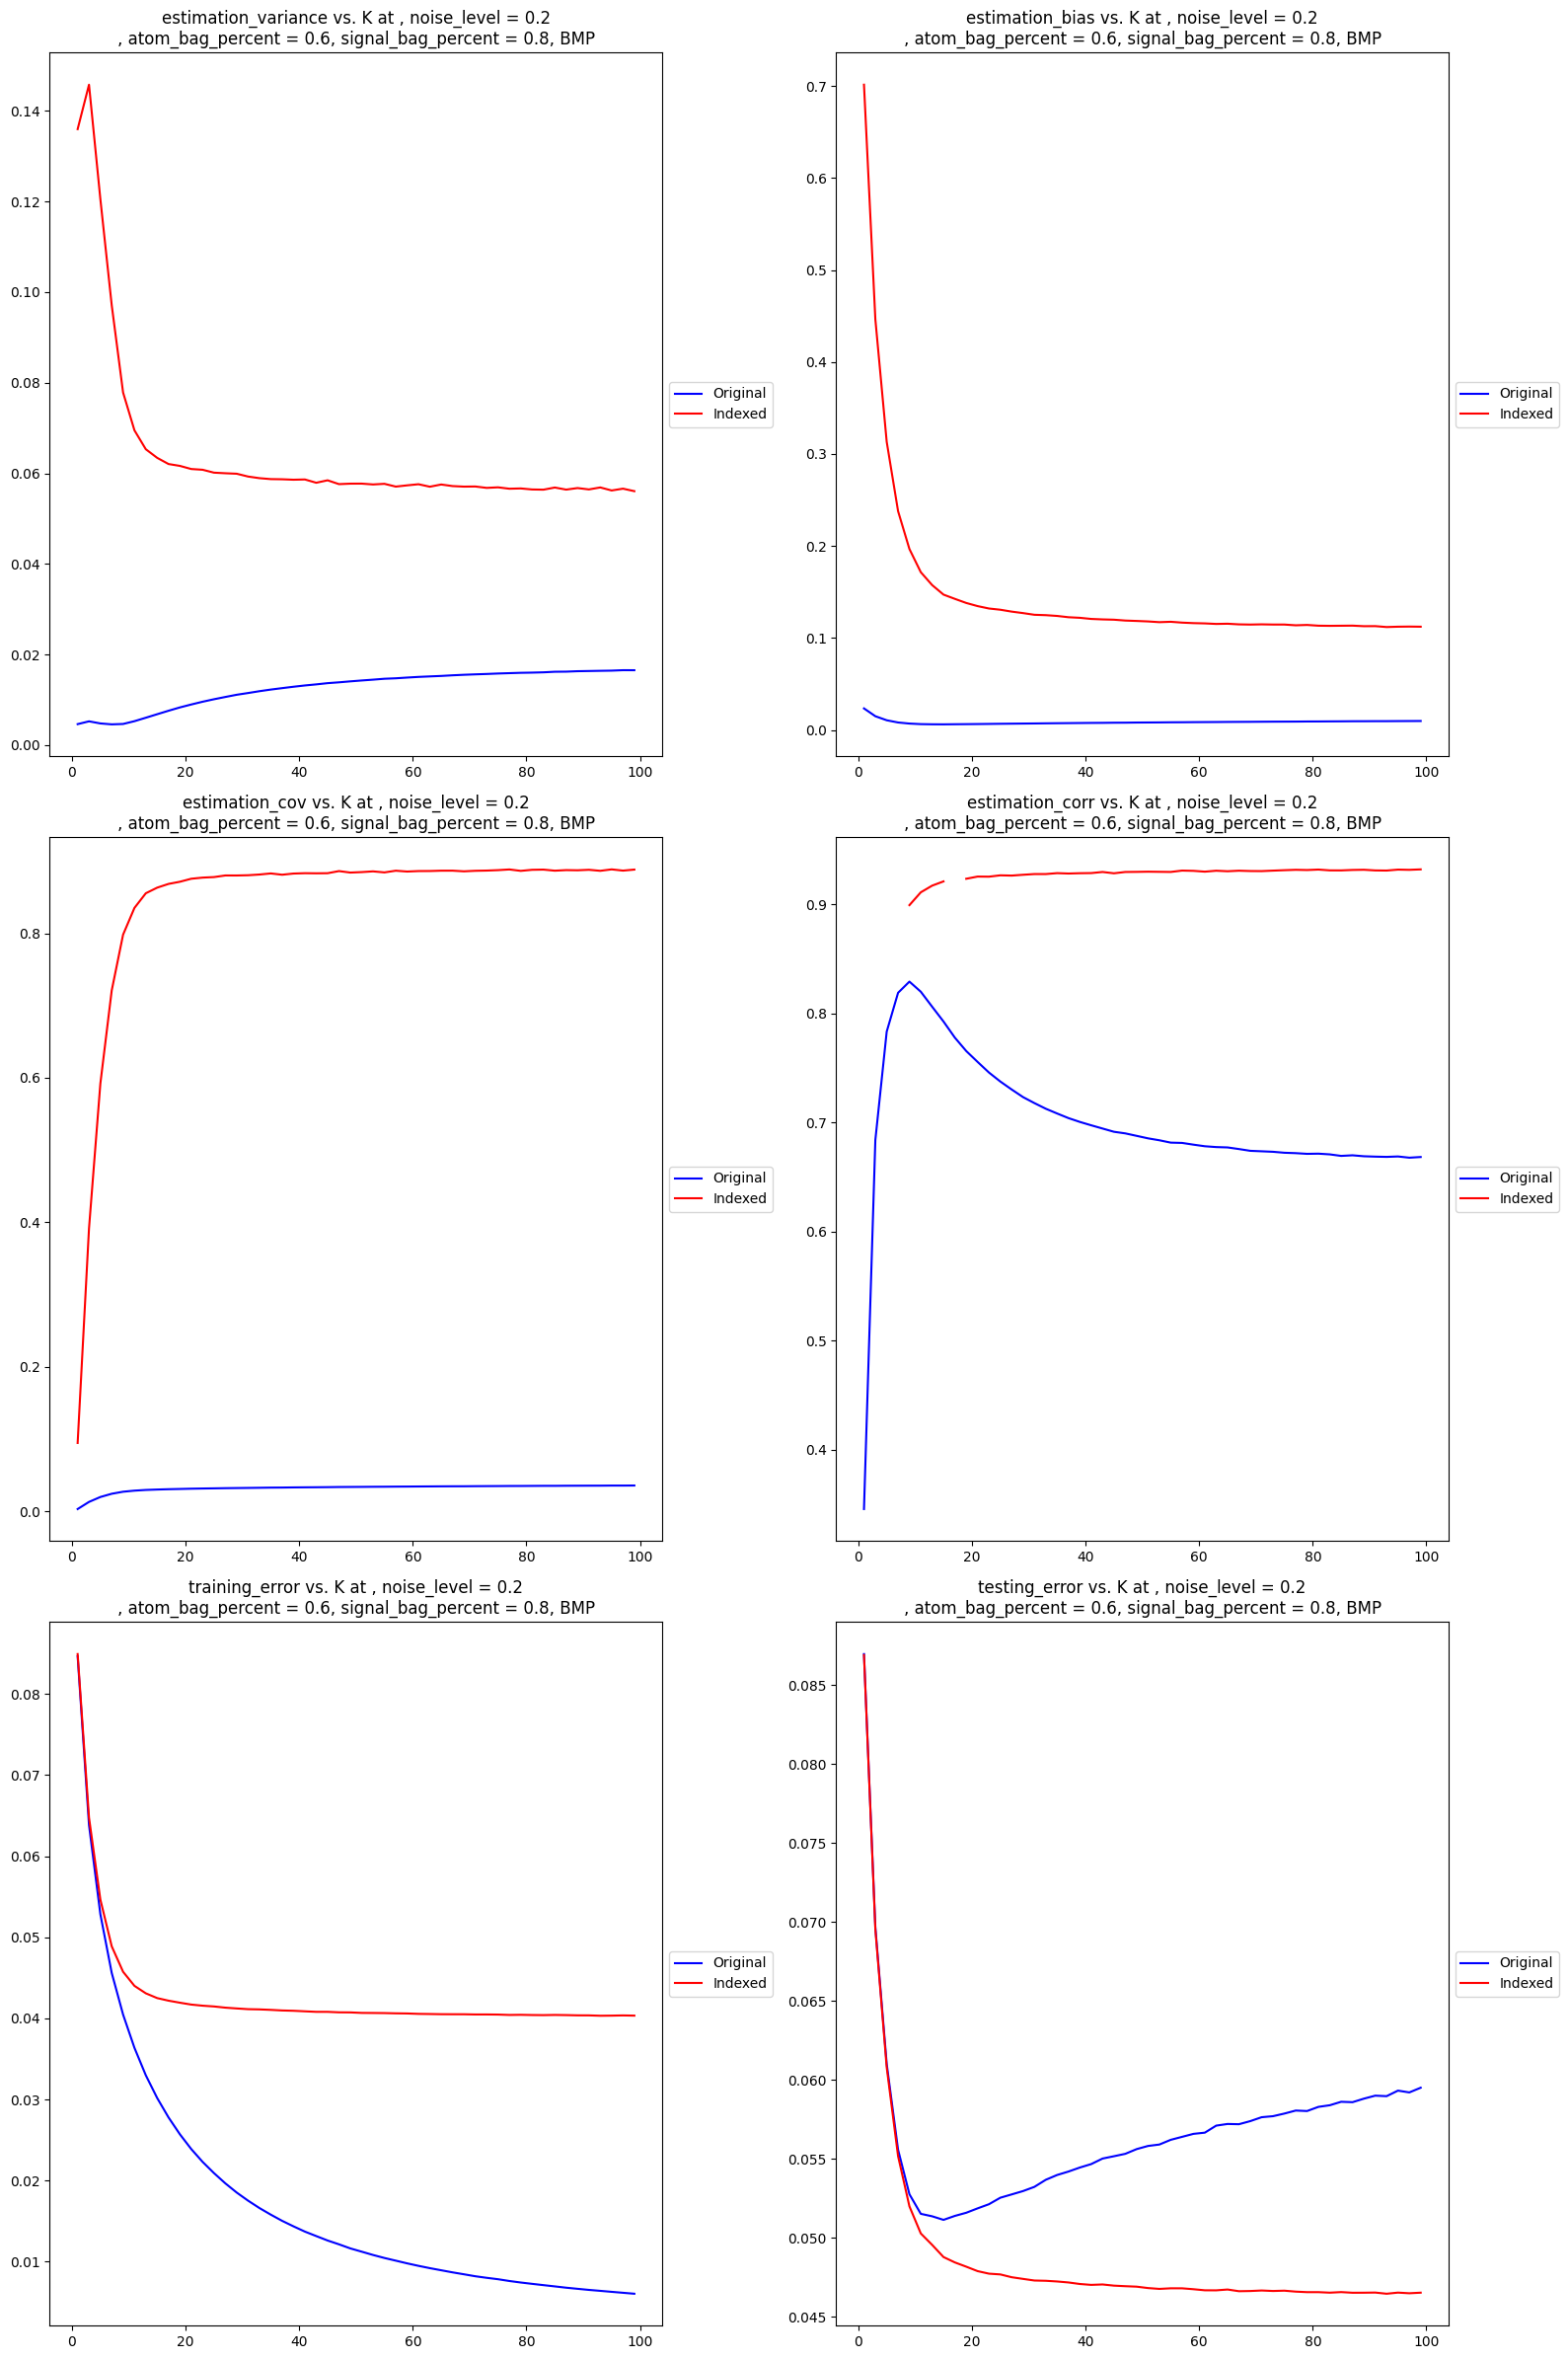

In [50]:
viz_for_single_pkl_file(pkl_files[2])

In [51]:
# def compare_results_from_different_pkls(list_of_pickle_files):
    
lists_of_pickle_files = [pkl_files[0],pkl_files[2]]


In [78]:
def aggregate_pickle_files(lists_of_pickle_files):
    # assuming *_mean variables are defined
    variable_names = ['estimation_variance', 'estimation_bias', 'estimation_cov', 'estimation_corr', 
                    'training_error', 'testing_error', 'indexed_estimation_variance', 'indexed_estimation_bias',
                    'indexed_estimation_cov', 'indexed_estimation_corr', 'indexed_training_error', 'indexed_testing_error']

    for variable_name in variable_names:
        exec(variable_name+'_list = []')
    lists_of_k_list = []
    lists_of_atom_bag_percent = []
    lists_of_signal_bag_percent = []



    for pkl_file_path in lists_of_pickle_files:
        temp_data, temp_data_parameters = data_loader(pkl_file_path)

        n, p, m, noise_level, model_name, signal_bag_percent, atom_bag_percent, trial_num = parameter_loader(temp_data_parameters)


        temp_data_log = temp_data['log'][0]
        K_list = temp_data['parameters']['param_grid']['K']
        lists_of_k_list.append(K_list)
        lists_of_atom_bag_percent.append(temp_data_parameters['fixed_params']['atom_bag_percent'])
        lists_of_signal_bag_percent.append(temp_data_parameters['fixed_params']['signal_bag_percent'])
        estimation_variance_mean, estimation_bias_mean, estimation_cov_mean, estimation_corr_mean, training_error_mean, testing_error_mean, indexed_estimation_variance_mean, indexed_estimation_bias_mean, indexed_estimation_cov_mean, indexed_estimation_corr_mean, indexed_training_error_mean, indexed_testing_error_mean = calculate_single_pkl_statistics(temp_data_log,temp_data_parameters, trial_num, K_list)

        for variable_name in variable_names:
            exec(variable_name+'_list.append('+variable_name+'_mean)')

    fig, axes = plt.subplots(3, 2, figsize=(18,24))  # 2 rows, 3 columns
    axes = axes.ravel()  # flatten axes

    # Create a new figure for each pair of variables
    for i, var_name in enumerate(['estimation_variance', 'estimation_bias', 'estimation_cov', 'estimation_corr', 
                                'training_error', 'testing_error']):
        for pkl_index in range(len(lists_of_pickle_files)):
            indexed_var_name = 'indexed_' + var_name
            # Add lines
            axes[i].plot(lists_of_k_list[pkl_index], eval(var_name + "_list")[pkl_index], label="a = " + str(lists_of_atom_bag_percent[pkl_index]) + ", s = " + str(lists_of_signal_bag_percent[pkl_index]))
            axes[i].plot(lists_of_k_list[pkl_index], eval(indexed_var_name + "_list")[pkl_index], label="a = " + str(lists_of_atom_bag_percent[pkl_index]) + ", s = " + str(lists_of_signal_bag_percent[pkl_index])+ " (indexed)")
        axes[i].set_title(var_name + f' vs. K between models')
        # Add legend
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    # Adjust the layout
    plt.tight_layout()

    # Save the figure before showing it
    plt.savefig(os.path.join(fig_sav_path, 'Comparison of different atom bagging and signal bagging percentages.png'), dpi=300)

    # Show the plot
    plt.show()

/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


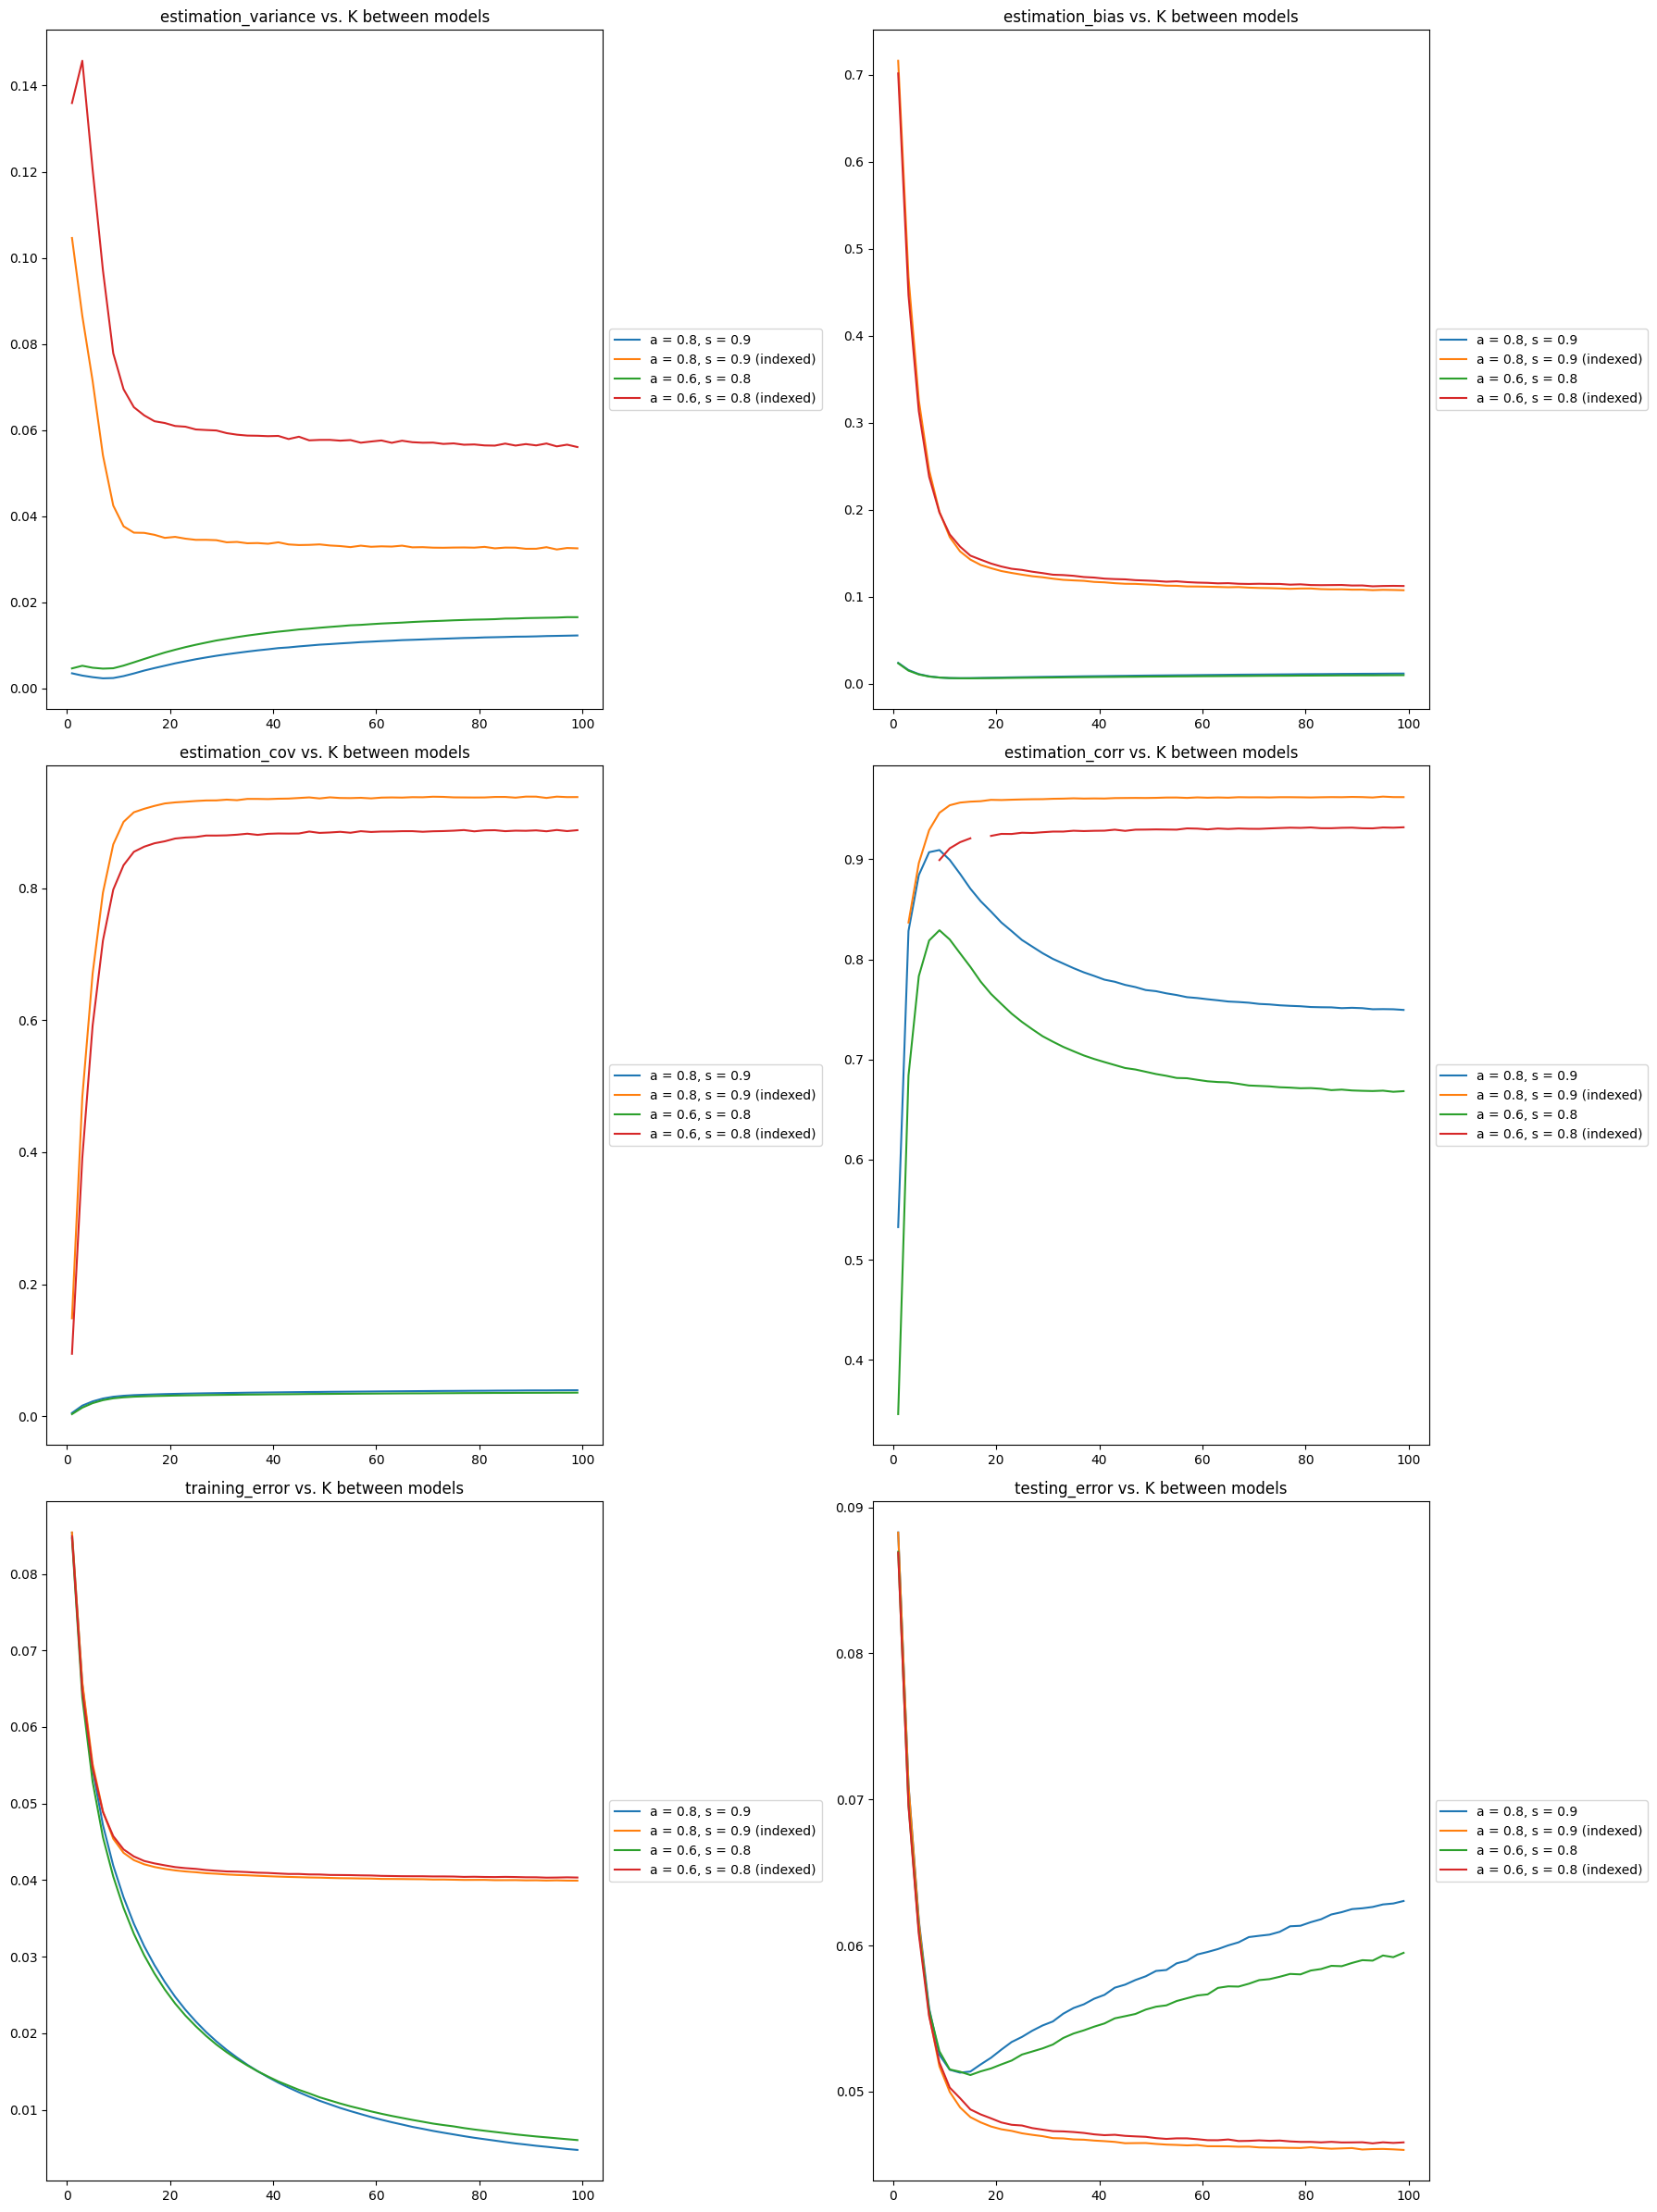

In [79]:
aggregate_pickle_files(lists_of_pickle_files)